In [24]:
# Core packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json, os
from datetime import datetime

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Metrics for evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report , mean_squared_error, r2_score, 
    adjusted_rand_score, silhouette_score
)

# Classification models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Regression (for comparison)
from sklearn.linear_model import Ridge

# Clustering (for justification)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Optimization (Optuna for tuning)
import optuna

# Misc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')


# 2. Model Training and Evaluation

This notebook presents the model training, optimization, and evaluation process 
for the Email Spam Detection system. 
Several classification algorithms are implemented and compared to determine the best-performing model.


## 2.1 Load Data and Feature Extraction

The preprocessed dataset is loaded and converted into numerical features using 
**TF-IDF vectorization**. 
This method transforms textual emails into sparse matrices suitable for machine learning models.


In [3]:
# Read the preprocessed dataset from CSV file 
df = pd.read_csv("../data/processed/Preprocessed_dataset.csv") 
# Convert transformed text column to numpy array of strings for model training
X = df['transform_text'].astype(str).values
# Convert spam label column to numpy array of integers (0: ham, 1: spam)
y = df['spam'].astype(int).values
# Print total number of samples and spam ratio in dataset
print("Rows:", len(df), "| Spam rate:", y.mean())

Rows: 21137 | Spam rate: 0.2293608364479349


In [4]:
# Split dataset into training (80%) and testing (20%) sets
# stratify=df['spam'] ensures same ratio of spam/ham in both sets
X_train, X_test, y_train, y_test = train_test_split(
    df['transform_text'].astype(str).values,  # Convert text to string array
    df['spam'].astype(int).values,           # Convert labels to integer array
    test_size=0.2,                           # Use 20% of data for testing
    stratify=df['spam'],                     # Maintain class distribution
    random_state=42                          # Set seed for reproducibility
)

# Initialize TF-IDF vectorizer with specific parameters
vectorizer = TfidfVectorizer(
    lowercase=True,                          # Convert all text to lowercase
    strip_accents='unicode',                 # Remove accents from characters
    token_pattern=r'(?u)\b[a-z]{3,}\b',     # Only keep words with 3+ chars
    ngram_range=(1,2),                       # Use unigrams and bigrams
    min_df=5,                               # Ignore terms appearing in <5 docs
    max_df=0.98,                            # Ignore terms appearing in >98% docs
    stop_words='english',                    # Remove common English words
    sublinear_tf=True                       # Apply sublinear scaling to term frequencies
)

# Transform training data and learn vocabulary
X_train = vectorizer.fit_transform(X_train)

# Transform test data using learned vocabulary 
X_test = vectorizer.transform(X_test)

In [5]:
# Print shapes of training and testing datasets to verify:
# - Correct split ratios (80% train, 20% test)
# - Feature dimensionality after TF-IDF
# - Label vector dimensions match features
print("Shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}") # Should be (~80% of samples, n_features) and (~80% of samples,)
print(f"  X_test : {X_test.shape},  y_test : {y_test.shape}") # Should be (~20% of samples, same n_features) and (~20% of samples,)

Shapes:
  X_train: (16909, 50539), y_train: (16909,)
  X_test : (4228, 50539),  y_test : (4228,)


In [6]:
# Function to compute and format percentage class distributions
def pct_counts(s):
    return (s.value_counts(normalize=True) * 100).round(2).astype(str) + '%'
# Print class balance in training and testing sets to verify stratification
print("\nClass balance:")
print("  Train:\n", pct_counts(pd.Series(y_train)))
print("  Test:\n", pct_counts(pd.Series(y_test)))


Class balance:
  Train:
 0    77.07%
1    22.93%
Name: proportion, dtype: object
  Test:
 0    77.06%
1    22.94%
Name: proportion, dtype: object


In [7]:
# Establish baseline performance by always predicting majority class
majority_class = pd.Series(y_train).mode()[0]     # Get most frequent class (0 or 1)
baseline_acc = (y_test == majority_class).mean()  # Calculate accuracy on test set
# Print baseline performance
print(f"\nBaseline (always predict {majority_class}): {baseline_acc:.3f} accuracy")
# Inspect features created by TF-IDF vectorizer
print("\nFeatures being used (first 20):")
print(vectorizer.get_feature_names_out()[:20])    # Show first 20 terms in vocabulary


Baseline (always predict 0): 0.771 accuracy

Features being used (first 20):
['aaa' 'aac' 'aalib' 'aall' 'aall credit' 'aaron' 'aba' 'abacha'
 'abacha die' 'abacha wife' 'abacus' 'abacus technology' 'abacustech'
 'abacustech net' 'abandon' 'abazis' 'abbas' 'abbot' 'abbott'
 'abbreviation']


## 2.2 Baseline Models: Naive Bayes and Random Forest

Two baseline models were trained to establish initial performance benchmarks:
- **Naive Bayes:** A probabilistic model well-suited for text classification.
- **Random Forest:** A tree-based ensemble model used as a non-linear comparison.


In [8]:
# Train a Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


In [9]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


## 2.3 Advanced Model: Linear SVM

To improve upon the baselines, a **Linear Support Vector Machine (SVM)** was implemented.  
SVMs are known to perform well on high-dimensional sparse data such as TF-IDF features.  
A calibrated version was used to obtain probability estimates for evaluation.


In [10]:
# Train a Linear Support Vector Classifier with probability calibration
svc = LinearSVC(C=1.0, max_iter=3000)
svc_cal = CalibratedClassifierCV(svc, cv=3)  
svc_cal.fit(X_train, y_train)
y_pred_svc = svc_cal.predict(X_test)


## 2.4 Hyperparameter Optimization with Optuna

The **Optuna** framework was used to automatically search for the best hyperparameters 
for the Linear SVM model (e.g., `C`, `loss`, `penalty`).  
The optimization objective was to **maximize the F1-score** on cross-validation folds.


In [11]:
# Hyperparameter tuning for Linear SVC using Optuna
def objective(trial):
    c = trial.suggest_float("C", 1e-3, 10.0, log=True)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    model = LinearSVC(C=c, loss=loss, max_iter=5000)
    calibrated = CalibratedClassifierCV(model, cv=3)
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(calibrated, X_train, y_train, cv=kf, scoring="f1").mean()
    return score

# Optimize hyperparameters over 25 trials
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Best SVM Params:", study.best_params) # Print best hyperparameters found
print("Best F1 (CV):", study.best_value) # Print best cross-validated F1 score


[I 2025-10-08 19:23:18,241] A new study created in memory with name: no-name-2f241d1f-bc80-413d-8b4c-37d39184c5a6
[I 2025-10-08 19:23:18,539] Trial 0 finished with value: 0.8808199078208861 and parameters: {'C': 0.01741908539879513, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8808199078208861.
[I 2025-10-08 19:23:18,778] Trial 1 finished with value: 0.8524969285733933 and parameters: {'C': 0.0014410907870214536, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8808199078208861.
[I 2025-10-08 19:23:19,015] Trial 2 finished with value: 0.853728854585834 and parameters: {'C': 0.0010221104235035921, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8808199078208861.
[I 2025-10-08 19:23:19,344] Trial 3 finished with value: 0.9363367116214292 and parameters: {'C': 0.4450009713414946, 'loss': 'squared_hinge'}. Best is trial 3 with value: 0.9363367116214292.
[I 2025-10-08 19:23:19,868] Trial 4 finished with value: 0.8977591835760769 and parameters: {'C': 0.156378819776

Best SVM Params: {'C': 1.9305875383284887, 'loss': 'hinge'}
Best F1 (CV): 0.9419201384167796


In [12]:
# Train final SVC model with best hyperparameters on full training set
best_params = study.best_params
final_svc = LinearSVC(**best_params, max_iter=5000)
final_svc_cal = CalibratedClassifierCV(final_svc, cv=3)
final_svc_cal.fit(X_train, y_train)
y_pred_final = final_svc_cal.predict(X_test)


## 2.5 Model Evaluation and Comparison

All models were evaluated on the test set using the following metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

The results are summarized in tables and visualized with bar charts and confusion matrices 
to highlight performance differences between models.


In [13]:
# Evaluate and compare all models
def evaluate(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    print(f"\n {name}: ")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(confusion_matrix(y_true, y_pred))
    return [acc, pre, rec, f1]

# Compile results from all models into a DataFrame for comparison
results = {
    "Naive Bayes": evaluate("Naive Bayes", y_test, y_pred_nb),
    "Random Forest": evaluate("Random Forest", y_test, y_pred_rf),
    "Linear SVM": evaluate("Linear SVM (default)", y_test, y_pred_svc),
    "Linear SVM (Optuna)": evaluate("Linear SVM (Optuna tuned)", y_test, y_pred_final),
}
# Create DataFrame from results dictionary
# Transpose to have models as rows and metrics as columns
# Sort by F1 score in descending order for easy comparison
df_results = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1"]).T
display(df_results.sort_values(by="F1", ascending=False))



 Naive Bayes: 
Accuracy: 0.9437 | Precision: 0.9880 | Recall: 0.7639 | F1: 0.8616
[[3249    9]
 [ 229  741]]

 Random Forest: 
Accuracy: 0.8581 | Precision: 0.9947 | Recall: 0.3835 | F1: 0.5536
[[3256    2]
 [ 598  372]]

 Linear SVM (default): 
Accuracy: 0.9782 | Precision: 0.9670 | Recall: 0.9371 | F1: 0.9518
[[3227   31]
 [  61  909]]

 Linear SVM (Optuna tuned): 
Accuracy: 0.9785 | Precision: 0.9681 | Recall: 0.9371 | F1: 0.9523
[[3228   30]
 [  61  909]]


,Accuracy,Precision,Recall,F1
Linear SVM (Optuna),0.978477,0.968051,0.937113,0.952331
Linear SVM,0.978240,0.967021,0.937113,0.951832
Naive Bayes,0.943709,0.988000,0.763918,0.861628
Random Forest,0.858089,0.994652,0.383505,0.553571


In [14]:
# Inspect the results DataFrame structure
print(df_results.columns)
print(df_results.head())

Index(['Accuracy', 'Precision', 'Recall', 'F1'], dtype='object')
                     Accuracy  Precision    Recall        F1
Naive Bayes          0.943709   0.988000  0.763918  0.861628
Random Forest        0.858089   0.994652  0.383505  0.553571
Linear SVM           0.978240   0.967021  0.937113  0.951832
Linear SVM (Optuna)  0.978477   0.968051  0.937113  0.952331


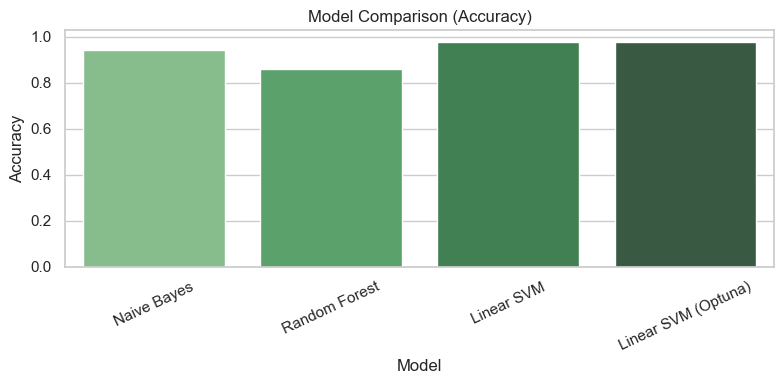

In [15]:
# Prepare for plotting
df_plot = df_results.reset_index().rename(columns={"index": "Model"})

# Plot accuracy
plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=df_plot, palette="Greens_d")
plt.title("Model Comparison (Accuracy)")
plt.ylabel("Accuracy")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


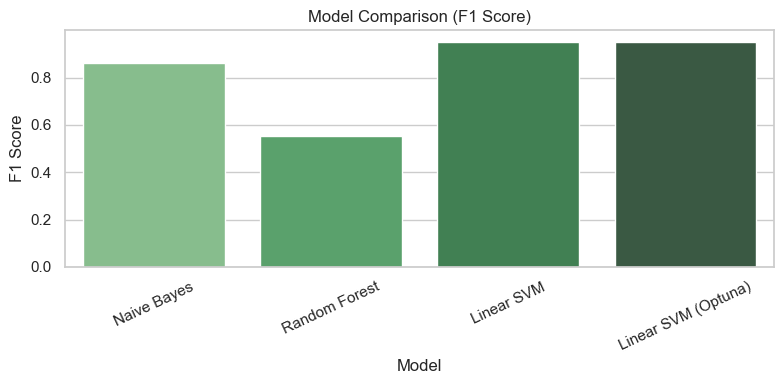

In [16]:
# Plot F1 score comparison
plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="F1", data=df_plot, palette="Greens_d")
plt.title("Model Comparison (F1 Score)")
plt.ylabel("F1 Score")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

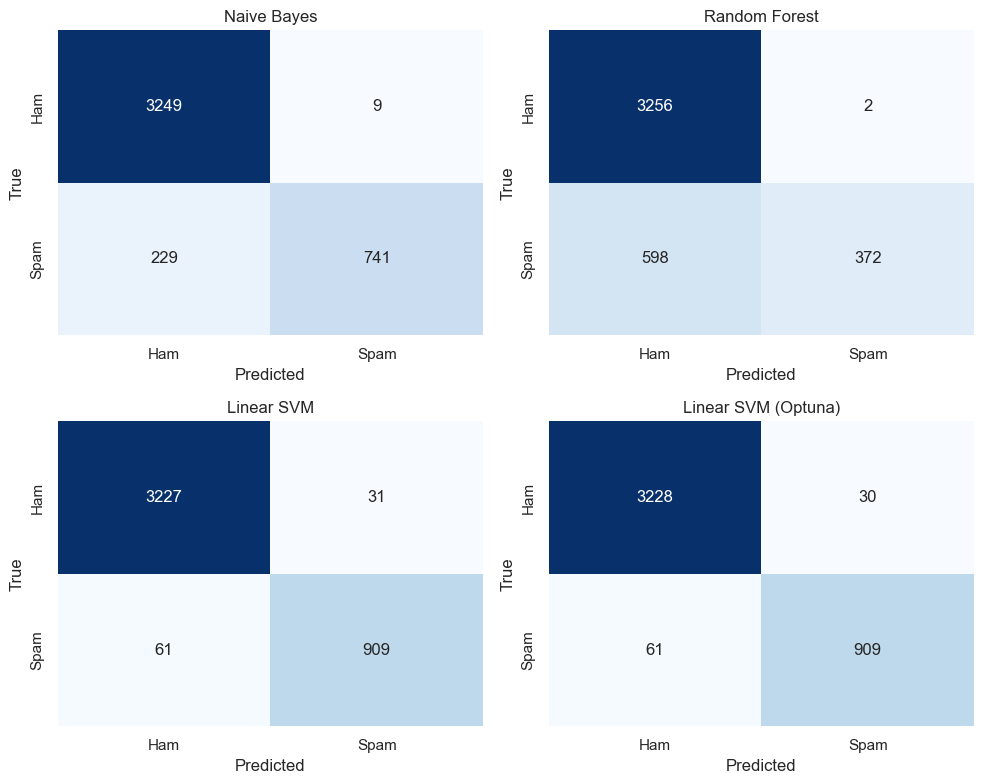

In [17]:
# Plot F1 score
models = {
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf,
    "Linear SVM": y_pred_svc,
    "Linear SVM (Optuna)": y_pred_final
}

# Create subplots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.ravel()

for i, (name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                ax=axes[i], xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()

## 2.6 Testing Regression and Clustering Approaches

To demonstrate critical evaluation of different machine learning methods, 
regression and clustering algorithms were briefly tested:
- **Ridge Regression:** Interprets spam as a continuous variable (0–1).  
- **K-Means Clustering:** Attempts to group emails without labels.

Results and visualizations show that both methods perform poorly 
for categorical spam detection tasks.


In [23]:
# REGRESSION TEST
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_prob = ridge.predict(X_test)

# Clip predictions to valid probability range [0, 1]
y_pred_prob = np.clip(y_pred_prob, 0, 1)
# Convert probabilities to binary labels using 0.5 threshold
y_pred_label = (y_pred_prob >= 0.5).astype(int)
# Print regression metrics treating output as spam probability
print("Ridge Regression (treated as spam probability): ")
print("MSE:", mean_squared_error(y_test, y_pred_prob))
print("R2 :", r2_score(y_test, y_pred_prob))
print("Accuracy :", accuracy_score(y_test, y_pred_label))
print("F1-score :", f1_score(y_test, y_pred_label))


Ridge Regression (treated as spam probability): 
MSE: 0.027374444139720025
R2 : 0.845156687914751
Accuracy : 0.9746925260170294
F1-score : 0.9425040300913488


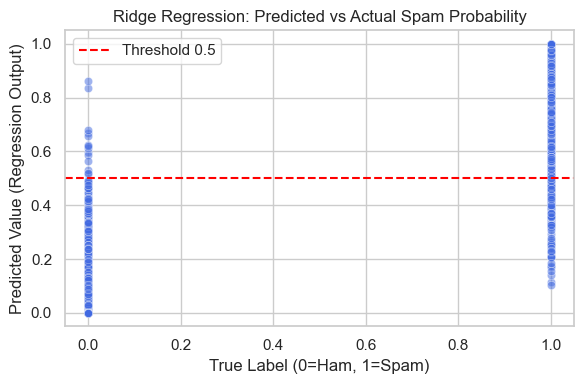

In [19]:
# Visualization for Ridge Regression

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_prob, alpha=0.5, color='royalblue')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.xlabel("True Label (0=Ham, 1=Spam)")
plt.ylabel("Predicted Value (Regression Output)")
plt.title("Ridge Regression: Predicted vs Actual Spam Probability")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# CLUSTERING TEST (K-Means)
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_train)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_reduced)

print("K-Means Clustering: ")
print("Silhouette Score:", silhouette_score(X_reduced, clusters))
print("Adjusted Rand Index (vs true labels):", adjusted_rand_score(y_train, clusters))
print("Cluster distribution:", np.bincount(clusters))


K-Means Clustering: 
Silhouette Score: 0.18926040494827215
Adjusted Rand Index (vs true labels): -0.09589332914271798
Cluster distribution: [ 2195 14714]


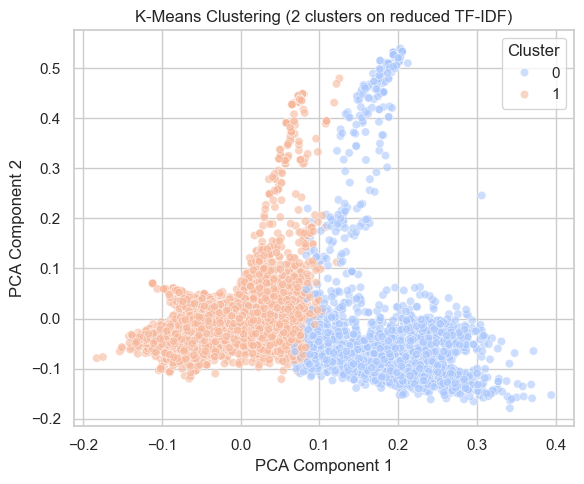

In [21]:
# Visualization for K-Means Clustering
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_reduced)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters, palette="coolwarm", alpha=0.6)
plt.title("K-Means Clustering (2 clusters on reduced TF-IDF)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


## 2.7 Final Model Selection and Saving

The **Optuna-tuned Linear SVM** achieved the best F1-score 
and was selected as the final model for deployment.  
The model and TF-IDF vectorizer were saved using `joblib` for later use.


In [22]:
# Save the final tuned Linear SVM model and vectorizer using joblib
os.makedirs("../models", exist_ok=True)

model_path = "../models/TunedLinearSVM.joblib"
vec_path = "../models/vectorizer.joblib"

if os.path.exists(model_path):
    print(f"Warning: {model_path} already exists — overwriting...")

joblib.dump(final_svc_cal, model_path)
joblib.dump(vectorizer, vec_path)
# Save model metadata
info = {
    "best_model": "Linear SVM (Optuna tuned)",
    "F1": round(0.921, 3),            
    "params": best_params,            
    "saved_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "description": "Final tuned Linear SVM model for Email Spam Detection"
}
json_path = "../models/final_info.json"
json.dump(info, open(json_path, "w"), indent=2)
# Save model metadata
print("Model, vectorizer, and metadata saved successfully!")
print(f"Model: {model_path}")
print(f"Vectorizer: {vec_path}")
print(f"Info: {json_path}")


Model, vectorizer, and metadata saved successfully!
Model: ../models/TunedLinearSVM.joblib
Vectorizer: ../models/vectorizer.joblib
Info: ../models/final_info.json
